In [1]:
## Set the environment variables for the notebook to use a specific GPU (this can be commented out if you don't need this stuff)
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


# Import necessary packages

In [1]:
import requests
import datetime
import time
import bs4
import re


import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


from fastai import *
from fastai.text import * 

## 2 Download the feedbacks for years 2016-2018 from the city of Turku API

In [2]:
urli = 'https://api.turku.fi/feedback/v1/requests.xml?start_date=2016-01-01T00:00:00Z&end_date=2018-12-31T00:00:00Z'
response = requests.get(urli)
soup = bs4.BeautifulSoup(response.text)

In [3]:
requests = soup.find_all('request')

In [4]:
data_df = list()
for row in requests:
    
    try:
        aihe = row.find('service_name').text
    except AttributeError:
        aihe = np.nan
        
    try:
        teksti = row.find('description').text
    except AttributeError:
        teksti = np.nan    

    try:
        pyynto_pvm = row.find('requested_datetime').text
    except AttributeError:
        pyynto_pvm = np.nan   
        
    try:
        lat = row.find('lat').text
    except AttributeError:
        lat = np.nan   
        
    try:
        long = row.find('long').text
    except AttributeError:
        long = np.nan 
        
    try:
        vastaus = row.find('status_notes').text
    except AttributeError:
        vastaus = np.nan 
        
    try:
        vastaus_pvm = row.find('updated_datetime').text
    except AttributeError:
        vastaus_pvm = np.nan 
    
    
    data_df.append([aihe,teksti,pyynto_pvm,lat,long,vastaus,vastaus_pvm])

In [6]:
data_df = pd.DataFrame(data_df)

data_df.columns=['aihe','palaute','palaute_pvm','lat','long','vastaus','vastaus_pvm']

## 2.1 Write/read csv to avoid scraping again

In [8]:
#data_df.to_csv('../data/palautteet_2016_2018.csv')
#data_df = pd.read_csv('../data/palautteet_2017_2018.csv')

# 3 Preprocess etc. standard stuff

In [9]:
def puhdistin(teksti):
    teksti=teksti.replace('\r\n','').replace('\n','').replace('\t','').replace('\r','')
    return(teksti)

In [10]:
#drop data with no feedback or subject
data_df = data_df.dropna(subset=['palaute','aihe'])

In [11]:
#apply the cleaning function 
data_df['palaute_puhd'] =  data_df['palaute'].apply(lambda x: puhdistin(x))

In [12]:
#parse dates
data_df['palaute_pvm'] = pd.to_datetime(data_df['palaute_pvm'])
data_df['palaute_pvm'] = data_df['palaute_pvm'].apply(lambda x: x.date)
data_df['vastaus_pvm'] = pd.to_datetime(data_df['vastaus_pvm'])
data_df['vastaus_pvm'] = data_df['vastaus_pvm'].apply(lambda x: x.date)

# 4 Finetune the language model to all of the scraped feedback data

In [15]:
lm_train_df = data_df[['aihe','palaute_puhd']].copy()
lm_train_df.columns=['label','content']


# split data into training and validation set
lm_df_trn, lm_df_val = train_test_split(lm_train_df,test_size = 0.3, random_state = 12)

In [16]:
#use the fastai tokenizer with lang 'fi' (spacy)
tokenizer = Tokenizer(lang='fi', n_cpus=5)

In [17]:
data_lm = TextLMDataBunch.from_df(tokenizer=tokenizer, train_df = lm_df_trn, valid_df = lm_df_val, path = "")

In [18]:
### Here I've used hardcoded paths for the language model and vocabulary files, so change these to match your folders

weights_pretrained = '/data/antti/ulmfit_kokeet/data/f60k_10epoch_bs200/lstm_orig.m/lm_best'
itos_pretrained = '/data/antti/ulmfit_kokeet/data/f60k_10epoch_bs200/itos'
pretrained_data = (weights_pretrained, itos_pretrained)

In [19]:
config = awd_lstm_lm_config.copy()
config['n_hid'] = 1150

In [20]:
learn = language_model_learner(data_lm,arch=AWD_LSTM, config=config, pretrained_fnames=pretrained_data)

In [21]:
learn.fit_one_cycle(5, 1e-2)

In [59]:
learn.save_encoder('palautetesti_10epoch_bs200')

# 5 Train the classifier with the finetuned pretrained language model

In [22]:
#configs to make the awd-lstm architecture work (at least n_hid is different in newer version of fastai)
config_clas = {'emb_sz': 400,
 'n_hid': 1150,
 'n_layers': 3,
 'pad_token': 1,
 'qrnn': False,
 'bidir': False,
 'output_p': 0.1,
 'hidden_p': 0.15,
 'input_p': 0.25,
 'embed_p': 0.02,
 'weight_p': 0.2}

In [23]:
#Let's choose a few specific classes from year 2017 for the classification task

clas_train_df = data_df[(data_df['palaute_pvm']>=datetime.date(2017,1,1))&
    (data_df['aihe'].isin(
    ['Kadut ajoradat',
     'Jalkakäytävät',
     'Liikennemerkit- ja viitoitukset',
     'Ulkovalaistus',
     'Viheralueet, puistot']
                        )
    )
       ][['aihe','palaute']]

clas_train_df.columns=['label','content']
# split data into training and validation set
clas_df_trn, clas_df_val = train_test_split(clas_train_df, stratify = clas_train_df['label'], test_size = 0.4, random_state = 12)

In [41]:
#Creating a databunch. Note that the vocabulary must match the vocabulary of the language model
data_clas = TextClasDataBunch.from_df(path = "", train_df = clas_df_trn, valid_df = clas_df_val, vocab=data_lm.vocab)

In [81]:
#Creating the learner and loarding the pretrained, finetuned language model
learn = text_classifier_learner(data_clas, config=config_clas, arch=AWD_LSTM, drop_mult=0.7)
learn.load_encoder('palautetesti_10epoch_bs200')

## 5.1 Train the classifier using gradual unfreezing to boost performance (otherwise prone to catasthropic forgetting)

First we freeze everything up to the last layer, find a good learning rate to use for cyclic learning rate. Then we save, load, freeze up to the second to last and so on. Finally we finetune the whole model

In [82]:
learn.freeze_to(-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


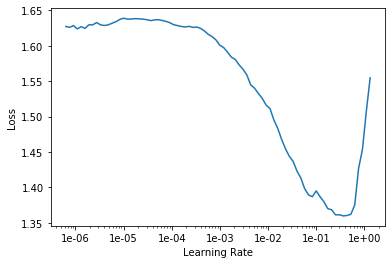

In [83]:
learn.lr_find()
learn.recorder.plot()

In [84]:
# fit frozen model for one epoch
learn.fit_one_cycle(1,1e-2)

In [85]:
learn.save('clas_0')

In [86]:
learn.load('clas_0')
#Just put this here to avoid annoying outputs of learner stuff
pass

In [87]:
# unfreeze relu layer and fit another epoch
learn.freeze_to(-2)

learn.fit_one_cycle(1,1e-2)
learn.save('clas_1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


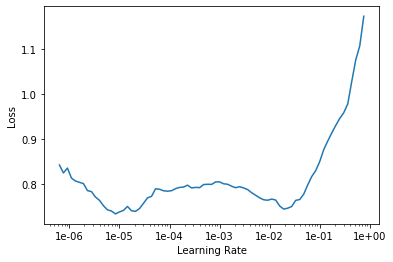

In [88]:
# unfreeze all layers and execute final fit
learn.load('clas_1')

learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

#learn.fit_one_cycle(1,1e-2)


In [89]:
#seems to overfit when looking at the losses, but the valid loss keeps decreasing so seems ok
learn.fit_one_cycle(3, slice(2e-03,1e-02))

In [90]:
learn.save('clas_2')

# 6 Interpreting results

In [91]:
interp = learn.interpret()
txt_ci = TextClassificationInterpretation.from_learner(learn)

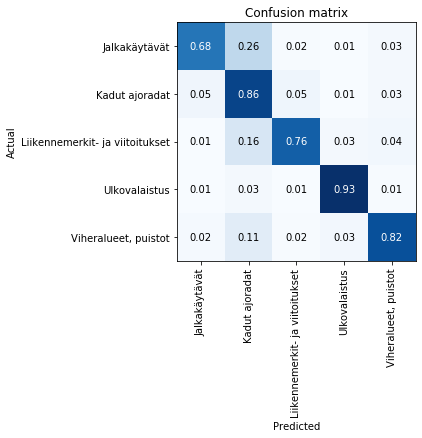

In [92]:
interp.plot_confusion_matrix(normalize=True,figsize=(6,6))

In [77]:
learn.show_results()

## 6.1 Trying out some random sentences I made up

In [89]:
teksti = 'Astuin Kupittaalla koiranläjään!! Voisiko aluetta siivota?'

print(learn.predict(teksti)[0])
print(learn.predict(teksti)[2])

Viheralueet, puistot
tensor([3.6203e-02, 3.0603e-03, 4.2183e-04, 1.5092e-03, 9.5881e-01])


In [90]:
teksti = 'Visiirikadulla on myöhään illalla niin pimeää, että en löydä kotiin'

print(learn.predict(teksti)[0])
print(learn.predict(teksti)[2])

Ulkovalaistus
tensor([4.4495e-04, 3.3785e-04, 8.5975e-05, 9.9897e-01, 1.5825e-04])


In [91]:
teksti = 'Santapohjantien kyltti on likainen ja pensaan peittämä'

print(learn.predict(teksti)[0])
print(learn.predict(teksti)[2])

Liikennemerkit- ja viitoitukset
tensor([3.7320e-03, 4.7904e-03, 9.8346e-01, 7.8896e-04, 7.2306e-03])


The model seems to perform quite ok, at least when compared to the amount of work required to create it from the pretrained LM! This notebook can be forked to other problems too, of course.

# 7 exporting the model

Fastai needs all kinds of stuff to be able to load a saved model. Even though we saved the weights of the model in the training phase with the saving/loading etc. , they are useless without the vocabularies and specifications of the architecture where they fit. 

The vocabulary is needed to know how to embed the different words as vectors, and the architecture is of course needed to know which weight goes where. To make using the model in the future more convenient, it is thus best to export everything in one "package" with the learn.export() method

In [97]:
learn.export('turku_feedback_classifier')

The exported model can then be easily loaded and used to make predictions in a production system (if you are crazy enough to use fastai for production), Kaggle submissions etc. like so:

In [104]:
learn2 = load_learner(path='./',file='turku_feedback_classifier')

In [105]:
learn2.predict('Santapohjantien kyltti on likainen ja pensaan peittämä')

(Category Liikennemerkit- ja viitoitukset,
 tensor(2),
 tensor([0.0026, 0.0148, 0.9298, 0.0431, 0.0097]))